# FuelEconomy.gov Vehicle Dataset

As part of the application for a Data Scientist role, this notebook aims to initially answer a few questions about the dataset and ultimately present a real world story on how fuel efficiency has evolved over time. 

## The Dataset

TLDR for this section: We' going to use `UCity` and `UHighway` as out main variables. Feel free to skip unless you want to know more about EPA methodology.

FuelEconomy.gov has compiled a number of Miles Per Gallon measurements for many vehicles since 1984, each in different measurement settings, e.g. city, highway, fuel types [1]. It's a large dataset with some cryptic column names, so we should get to know it well before any number crunching.

According to the website, these fuel economy measurements are taken in a lab with controlled conditions according to EPA specifications. A dynamometer is used to simulate travel under different conditions, varying resistance and speed. The fuel usage is then measured by the amount of carbon exhausted during the exercise, and compared against the simulated travel distance to calculate the resulting fuel economy [2].

In addition, the EPA changes the testing methodology every few years to take into account how changes in driver behavior, vehicle technology and driving conditions affect fuel usage, using data from previous years [5]. This change in methodology will reveal itself to be relevant for this analysis.

Our main variables of interest are those that provide a measurement of miles per gallon. They are:

|      A |       B |       C |        D | E | F |      G   |
| ------ | ------- | ------- | -------- | - | - | ------   |
| city08 | city08U | cityA08 | cityA08U | UCity | UCityA | phevCity |
| comb08 | comb08U | combA08 | combA08U | N/A | N/A  | phevComb  |
| highway08 | highway08U | highwayA08 | highwayA08U | UHighway | UHighwayA| phevHwy |

That's 19 variables of interest! That's a lot to process. Let's break this down:

Note that a simpler way to represent these measurements are as a  a combination of simulation conditions and methodology: `city, comb, highway` with `08, 08U, A08, A08U, U, U\*A, phev`. What do these titles refer to?

The first group is straightforward: measurements taken in a city setting, a highway setting. `comb` refers to a weighted average of city and highway MPG values (.55 and .45 respectively) [3].

The second group requires some explanation that can be found in the rest of the FuelEconomy.gov website:
- `08`: Our best guess is this reflects the 2008 update to EPA methodology to account for *"(1) faster speeds and acceleration, (2) air conditioner use, and (3) colder outside temperatures"* [4].
- `08U`: "Unrounded". Same value as above, but not rounded to nearest integer. Cursory inspection shows this value is zero before 2011. We'll investigate this.
- `A08`: "Alternative fuel", e.g. E85, Electricity, CNG, LPG.
- `A08U`: "Unrounded Alternative Fuel", for the above definition of unrounded.
- `U`: "Unadjusted", according to the adjustments made by the EPA so that measurements for cars made between 2011-2016 are comparable to 2017 and newer.
- `U\*A`: "Unadjusted Alternative Fuel", for the above definition of unadjusted [4].
- `phev`: MPG gasoline equivalent (MPGe) for plug-in hybrid electric vehicles (phev).

Before we look into fuel economy, let's consider how we can compare vehicle by model year taking into account the changes in the EPA's methodology [5].

- 1984-2007: Original measurements have been adjusted to be consistent with 2008 methodology.
- 2008-2010: Calculated with 2008 methodology.
- 2011-2016: Adjusted to match 2017 calculations, ratings changes guaranteed to be small (1-2 mpg lower than the originally calculated values).
- 2017-    : Calculated with most recent methodology.

The takeaway here is that there's no guarantee by the EPA that values between 1984-2010 model fuel efficiency and those of 2011-2017 are comparable!

We'll keep it simple and stick to UCity and UHighway, as these values are present for most of the dataset.

[1. FuelEconomy.gov Web Services](https://www.fueleconomy.gov/feg/ws/index.shtml#ft11)

[2. How Vehicles Are Tested](https://www.fueleconomy.gov/feg/how_tested.shtml)

[3. Gasoline Vehicles:
Learn More About the Label](https://www.fueleconomy.gov/feg/label/learn-more-gasoline-label.shtml)

[4. 2017 Ratings Changes](https://www.fueleconomy.gov/feg/ratings.shtml)

[5. Basic Information on Fuel Economy Labeling](https://www.epa.gov/fueleconomy/basic-information-fuel-economy-labeling)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

import statsmodels.api as sm
from patsy import dmatrices

df = pd.read_csv("vehicles.csv", low_memory=False)

## Which manufacturer produces the most fuel efficient fleet of cars?

For that, let's define "efficient": Because we have more than one measurement of efficiency, we'll create a combined 'UComb' variable like the EPA did for other MPG variables, defined as a weighted mean between UCity and UHighway.

In [2]:
df['UComb'] = .55 * df['UCity'] + .45 * df['UHighway']
fleet = df[['UComb', 'UCity', 'UHighway', 'make']]
fleet.groupby(by='make').mean().sort_values(by='UComb', ascending=False).head()

,UComb,UCity,UHighway
make,,,
Tesla,129.735776,127.505172,132.462069
CODA Automotive,104.315000,110.300000,97.000000
BYD,96.400538,95.778233,97.161133
smart,89.802383,92.472678,86.538689
Azure Dynamics,88.490000,88.400000,88.600000


However, older manufacturers are at a disadvantage according to this table, as the older models bring the mean efficiency down.

The question is posed in the present, therefore we will consider that only cars from 2018 and newer are still produced:

In [3]:
current_fleet = df[['UComb', 'UCity', 'UHighway', 'make']][df.year >= 2018]
current_fleet.groupby(by='make').mean().sort_values(by='UComb', ascending=False).head()

,UComb,UCity,UHighway
make,,,
smart,156.705000,173.850000,135.750000
Tesla,142.075500,142.080000,142.070000
BYD,103.285000,104.500000,101.800000
Fiat,47.562172,41.880514,54.506421
Hyundai,44.545759,39.393111,50.843440


Now Fiat and Hyundai are on the list, and smart on top, with the most efficient fleet currently in production.

## A model to predict city mpg

Can we derive the city fuel economy from other variables?

On a hunch, let's try UHighway. It would seem reasonable that there's a more or less linear relationship between city and highway efficiencies.

We'll start with a visual inspection:

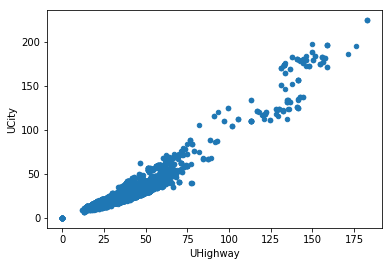

In [4]:
df.plot.scatter('UHighway', 'UCity')

Seems like the relationship is not perfectly linear, but almost.

We have a single train/test split, and K-fold cross validation would be more robust, but for simplicity we'll just use a single split.

In [5]:
# Helper functions
def sm_regression(model, x_train, y_train, x_test, y_test):
    m = model(y_train, x_train)
    m = m.fit()
    print(m.summary())
    
    pred = m.predict(x_train)
    print("\n======= Training vs Testing set performance: =================================")
    print("\tTraining RMSE     : %.2f" % mean_squared_error(y_train, pred)**(1/2))
    print("\tTraining R-squared: %.2f" % r2_score(y_train, pred))
    pred = m.predict(x_test)
    print("\tTesting RMSE      : %.2f" % mean_squared_error(y_test, pred)**(1/2))
    print("\tTesting R-squared : %.2f" % r2_score(y_test, pred))
    
    return m
    
def make_dummy(data, category, prefix):
    # Creates dummies with preserved index
    dummies = pd.get_dummies(data[category], prefix=prefix)
    dummies = dummies.set_index(data.index)
    # Rename columns to remove spaces
    replace = lambda s: s.replace(" ", "_").replace("/","_").replace(",","_").replace("-","_")
    dummies = dummies.rename(replace, axis='columns')
    return dummies

df_train = df.sample(frac=0.8, random_state=1337)
df_test = df.drop(df_train.index)

In [6]:
# Model 1: UCity ~ UHighway

y_train, x_train = dmatrices('UCity ~ UHighway', data=df_train, return_type='dataframe')
y_test, x_test = dmatrices('UCity ~ UHighway', data=df_test, return_type='dataframe')

lm = sm_regression(sm.OLS, x_train, y_train, x_test, y_test)

                            OLS Regression Results                            
Dep. Variable:                  UCity   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                 1.875e+05
Date:                Mon, 20 May 2019   Prob (F-statistic):               0.00
Time:                        00:15:55   Log-Likelihood:                -89750.
No. Observations:               32065   AIC:                         1.795e+05
Df Residuals:                   32063   BIC:                         1.795e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.5264      0.074   -101.921      0.0

Not bad for a single variable! Let's interpret the results:

- The R-squared score is decently high.
- RMSE shows we're only missing by 4 MPG on average.
- P-values are under 5%.
- For each 1 MPG increase in UHighway, we have a 0.89 MPG increase in UCity.
- It's important to compare Training vs Testing performance to avoid overfitting. So far this is not happening.

However, we can most likely improve the model. Notice that the intercept (that is, the value of UCity when UHighway is zero) is -7. That makes no sense. There are two hypothesis we can investigate that might solve that:

1. The intercept is zero. That is, for a vehicle that does 0 MPG on the highway, it would also do 0 MPG in city conditions.
2. Looking back at the graph, you may notice the relationship between Highway MPG and City MPG is not linear. Our model should account for that. One solution to solve this is by using a log-log model.

                            OLS Regression Results                            
Dep. Variable:               ln_UCity   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.946e+07
Date:                Mon, 20 May 2019   Prob (F-statistic):               0.00
Time:                        00:15:55   Log-Likelihood:                 27213.
No. Observations:               32065   AIC:                        -5.442e+04
Df Residuals:                   32064   BIC:                        -5.442e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
ln_UHighway     0.8890      0.000   5427.638      

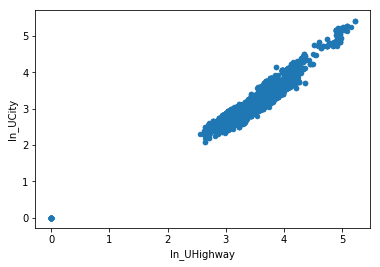

In [7]:
# Use log-log model to linearize the relationship:
# This is equivalent to modeling percentage increases between UHighway and UCity.
df_train['ln_UCity'] = np.log(1 + df_train['UCity'])
df_train['ln_UHighway'] = np.log(1 + df_train['UHighway'])
df_test['ln_UCity'] = np.log(1 + df_test['UCity'])
df_test['ln_UHighway'] = np.log(1 + df_test['UHighway'])

# Run model with intercept zero
eq = 'ln_UCity ~ ln_UHighway - 1'

y_train, x_train = dmatrices(eq, data=df_train, return_type='dataframe')
y_test, x_test = dmatrices(eq, data=df_test, return_type='dataframe')

lm = sm_regression(sm.OLS, x_train, y_train, x_test, y_test)

df_train.plot.scatter('ln_UHighway', 'ln_UCity')

The model makes more sense now!

1. The intercept is zero for UCity, solving our first model specification issue.
2. By using the log-log model, the relationship between them is linearized, although it changes how we interpret the model. We are now modeling percentage change between the variables.

Now, for each percent of increase in UHighway, we have a 0.89% increase in UCity.

As a bonus, the R-squared has also improved and our error for UCity is 10 percentage points on average.

Also note some entries have all zero values for UCity, UHighway, for all fuel types. No explanation was given on what this means. Normally this would be an argument to remove them from our analysis on the basis it's noise, but our model can still accomodate this, thanks to the decision of adopting a zero intercept.

For our next model, consider that technology improves over time. Perhaps with every passing year, the behavior of UCity changes. Does it?

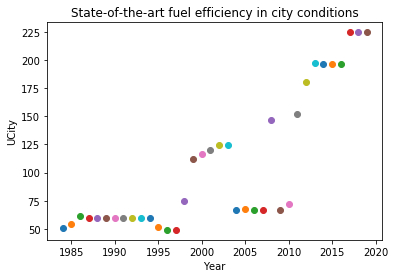

In [8]:
# State-of-the-art efficiency by year
groups = df.groupby('year')

fig, ax = plt.subplots()
for year, group in groups:
    top = group.sort_values(by='UCity', ascending=False).head(1)
    ax.plot(year, top['UCity'], marker='o', linestyle='', label=top['make'])
# ax.legend(loc='upper left', bbox_to_anchor=(0,-0.1), ncol=5)
plt.xlabel('Year')
plt.ylabel('UCity')
plt.title('State-of-the-art fuel efficiency in city conditions')
plt.show()

In [9]:
# "Reset" the year first to avoid numerical issues
df_train['year_adj'] = df_train['year'] - 1984
df_test['year_adj'] = df_test['year'] - 1984

eq = 'ln_UCity ~ ln_UHighway + year_adj - 1'

y_train, x_train = dmatrices(eq, data=df_train, return_type='dataframe')
y_test, x_test = dmatrices(eq, data=df_test, return_type='dataframe')

lm = sm_regression(sm.OLS, x_train, y_train, x_test, y_test)

                            OLS Regression Results                            
Dep. Variable:               ln_UCity   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.516e+07
Date:                Mon, 20 May 2019   Prob (F-statistic):               0.00
Time:                        00:15:56   Log-Likelihood:                 27680.
No. Observations:               32065   AIC:                        -5.536e+04
Df Residuals:                   32063   BIC:                        -5.534e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
ln_UHighway     0.8971      0.000   2909.192      

Our model hasn't improved much. Although year has a low p-value, we'll follow Occam's razor and remove it.

It might be the case that while UCity has changed over time (as we have seen previuously), this is already reflected in UHighway, thus it provides very little additional explanatory value.

Next: Let's take a step back and consider that the vehicles here draw from a variety of energy sources, with varying combustion power, and sometimes more than one energy source.

Hybrid and Electric particularly are known for reabsorbing brake energy, so it's reasonable to expect they would behave more efficiently in a city setting.

For that, we'll have to process these categorical values into dummy variables.

In [10]:
dummies_1_train = make_dummy(df_train, 'fuelType1', prefix='f1')
dummies_2_train = make_dummy(df_train, 'fuelType2', prefix='f2')

dummies_1_test = make_dummy(df_test, 'fuelType1', prefix='f1')
dummies_2_test = make_dummy(df_test, 'fuelType2', prefix='f2')

df2_train = pd.concat([df_train, dummies_1_train, dummies_2_train], axis=1, sort=False)
df2_test = pd.concat([df_test, dummies_1_test, dummies_2_test], axis=1, sort=False)

assert list(dummies_1_train.columns) == list(dummies_1_test.columns)
assert list(dummies_2_train.columns) == list(dummies_2_test.columns)

columns = ['ln_UHighway'] + list(dummies_1_train.columns) + list(dummies_2_train.columns)

eq = 'ln_UCity ~ ' + ' + '.join(columns) + ' - 1'

y_train, x_train = dmatrices(eq, data=df2_train, return_type='dataframe')
y_test, x_test = dmatrices(eq, data=df2_test, return_type='dataframe')

lm = sm_regression(sm.OLS, x_train, y_train, x_test, y_test)

                            OLS Regression Results                            
Dep. Variable:               ln_UCity   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                 3.489e+04
Date:                Mon, 20 May 2019   Prob (F-statistic):               0.00
Time:                        00:15:56   Log-Likelihood:                 33088.
No. Observations:               32065   AIC:                        -6.615e+04
Df Residuals:                   32054   BIC:                        -6.606e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
ln_UHighway              0.9643 

That's a bit of improvement! An additional 4p.p. in R-squared and a lower RMSE in both sets.

# Fuel economy over time

How has fuel economy progressed through time and what are trends we notice? Let's use UComb for this analysis as a proxy for general fuel economy.

Consider the petroleum consumption vs fuel efficiency chart. For easier visualization, efficiency values are in log, due to the difference in scale between the state-of-the-art (orange) and the mean (blue).

Text(0.5, 1.0, 'Petroleum consumption vs. Fuel Efficiency')

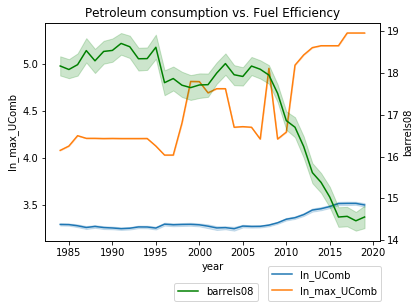

In [11]:
groups = df[['year', 'UComb']].groupby('year')
df_soa = groups.max()
df_soa['ln_max_UComb'] = np.log(1 + df_soa['UComb'])

df['ln_UComb'] = np.log(1 + df['UComb'])

df_plot = pd.merge(df, df_soa, on='year')

ax = sns.lineplot('year', 'ln_UComb', label='ln_UComb', data=df_plot.sort_values(by='year'))
ax = sns.lineplot('year', 'ln_max_UComb', label='ln_max_UComb', data=df_plot.sort_values(by='year'))
plt.legend(loc='lower left', bbox_to_anchor=(0.65, -.3))
ax2 = ax.twinx()
ax2 = sns.lineplot('year', 'barrels08', label='barrels08', data=df_plot.sort_values(by='year'), ax=ax2, color='green')
plt.legend(loc='lower right', bbox_to_anchor=(0.65, -.3))
plt.title("Petroleum consumption vs. Fuel Efficiency")

It's possible to visually separate the state-of-the-art into 3 periods:

1. From 1985 until the late 1990s, efficiencies were pretty much stable.
2. Late 1990s until 2009.
3. 2009 to present day.

One may argue that the driving force behind the two transitions is a combination of political and economic forces.

Namely:
1. The high price of oil in the late 1990s drove buyers to prefer more efficient vehicles, pressuring manufacturers to produce more efficient cars [6].
2. President Obama mandated goals for fuel efficiency by 2025 [7].

The average efficiency is much lower than the state-of-the-art, but slowly follows the trend.

Consumption of barrels is curiously positively correlated with the state-of-the-art during the first period, but after then is inversely correlated as would be expected.


[6] https://www.macrotrends.net/1369/crude-oil-price-history-chart

[7] https://www.nytimes.com/2009/05/19/business/19emissions.html


Can we see a similar trend in the fuels used by vehicle models over time? For this, we can count the amount of models that use each type of fuel for its main source of energy.

Text(0.5, 1.0, 'Number of models per main fuel category')

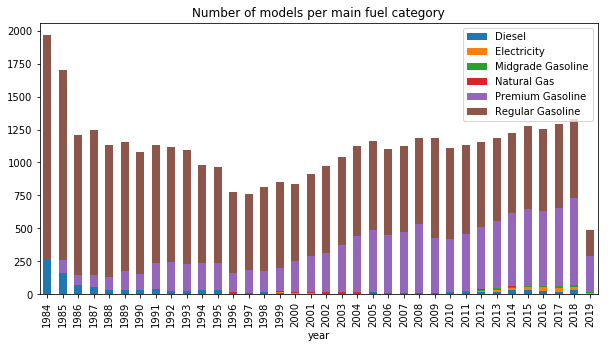

In [12]:
fuel1 = df.groupby(['year']).fuelType1.value_counts().unstack(0).T.plot.bar(stacked=True, figsize=(10,5))

plt.legend(loc='upper right')
plt.title("Number of models per main fuel category")

We may note:
- Gasoline is still the fuel of choice.
- The amount of diesel vehicles released has dropped quickly since 1984, but persistes to this day.
- Since 1999, Natural Gas powered vehicles have been introduced until the mid 2000s, likely as a response to rising oil prices.
- Electricity as a main energy source has been rising since the early 2010s. This is likely an effort to meet the 2025 fuel efficiency goals, as well as to keep up with rising sustainability trends.

Text(0.5, 1.0, 'Number of models using alternative fuel')

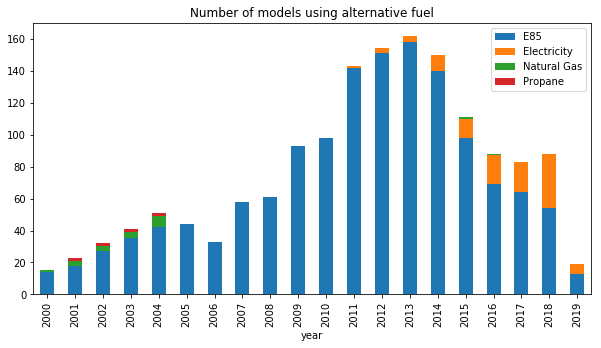

In [13]:
fuel2 = df.groupby(['year']).fuelType2.value_counts().unstack(0).T.plot.bar(stacked=True, figsize=(10,5))

plt.legend(loc='upper right')
plt.title("Number of models using alternative fuel")

Natural gas and propane as alternative fuels started becoming a more common release in the 2000s, probably due to a combination of high oil prices and not enough technological advancements to enable electric cars as a feasible option for the market.

Merely two years after the fuel efficiency goals were mandated, a few models using electricity as an alternative fuel were introduced, with a steady growth to this day.

While electric cars are state-of-the-art in terms of fuel efficiency, they are still the minority in the market and the economy still dependent on oil for the most part.

## What was left out

Because this is intended as a short challenge for a Data Scientist position, there's a lot we didn't cover here: How the EPA methodology works, its flaws, assumptions and unexplained details about the dataset. ["The Volkswagen emissions scandal"](https://en.wikipedia.org/wiki/Emissionsgate) is an interesting read.

The assumptions behind the linear regression models were also handwaved. The strongest assumption we used is that the underlying data is normally distributed. Visually, there's some level of heteroskedasticity between UCity and UHighway that we haven't addressed, which means the errors are not independent of UHighway, thus biasing the standard error (and therefore t-statistics and p-values).

For the fuel economy history section, a regression model for efficiency using dummies for each of the three periods would have served as a hypothesis test for these claims.

Finally, we could have modelled trends in fuel usage and engine types for the coming years to predict future fuel efficiency.